# Multiclass Classification (CIFAR10 MLP)

The goal is to assign an input data example $x$ to one of $K>2$ classes, so $y \in \{1, 2, ..., K\}$.

We select the categorical distribution, which is defined on the domain $\{1, 2, ..., K\}$. This distribution has $K$ parameters $\lambda_1, \lambda_2, ..., \lambda_K$, which determine the probability of each category:

$$
p(y=k) = \lambda_k
$$

The parameters are constrained to take values between 0 and 1, and they must collectively sum to 1 to ensure a valid probability distribution.

We use a network $f_\theta(x)$ with $K$ outputs to compute these $K$ parameters from the input $x$. Unfortunately, the network outputs will not necessarily obey the aforementioned constraints. Consequently, we pass the $K$ outputs of the network through a function that ensures these constraints are respected.

A suitable function is the **softmax function**. This takes an arbitrary vector of length $K$ and returns a vector of the same length but where the elements are now in the range $[0, 1]$ and sum to one.
The $k^\text{th}$ output of the softmax function is:

$$
\text{softmax}_{k}(z) = \frac{\exp(z_k)}{\sum_{k'=1}^{K}\exp(z_k')}
$$

where the exponential functions ensure positivity, and the sum in the denominator ensures that the $K$ numbers sum to one.

The likelihood that input $x$ has label $y=k$ is:

$$
p(y=k|x) = \text{softmax}_{k}(f_\theta(x))
$$

The loss function is the negative log-likelihood of the training data:
$$
\begin{align}
L(\theta) & = -\sum_{i=1}^{N}\log [p(y=y_i|x_i)] \\
& = -\sum_{i=1}^{N}\log [\text{softmax}_{y_i}(f_\theta(x_i))] \\
& = -\sum_{i=1}^{N} \left( f^{y_i}_\theta(x_i) -\log \left[\sum_{k'=1}^{K} \exp[f^{k'}_\theta (x_i) \right] \right)\\
\end{align}
$$

where $f^{y_i}_\theta(x_i)$ and $f^{k'}_\theta (x_i)$ denote the $y_i^{\text{th}}$ and $k'^{\text{th}}$ outputs of the network, respectively.

This is known as the **multiclass cross-entropy** loss.

The transformed model output represents a categorical distribution over possible classes $y \in \{1, 2, ..., K\}$. 

For a point estimate, we take the most probable category $\hat{y}=\underset{k}{\mathrm{argmax}} \; p(y=k|f_{\hat{\theta}}(x))$.

## Data

- https://paperswithcode.com/dataset/cifar-10

The CIFAR-10 dataset (Canadian Institute for Advanced Research, 10 classes) is a subset of the Tiny Images dataset and consists of 60000 32x32 color images. The images are labelled with one of 10 mutually exclusive classes: airplane, automobile (but not truck or pickup truck), bird, cat, deer, dog, frog, horse, ship, and truck (but not pickup truck). There are 6000 images per class with 5000 training and 1000 testing images per class..

In [ ]:
import torch
from torchvision import datasets
import torchvision.transforms.v2 as T

import matplotlib.pyplot as plt

In [ ]:
transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.ToPureTensor(),
])

In [ ]:
dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

n_val = int(len(dataset_test)*0.2)
n_test = len(dataset_test) - n_val

dataset_test, dataset_val = torch.utils.data.random_split(dataset_test, [n_test, n_val])

In [ ]:
print(f"Train: {len(dataset_train)}")
print(f"Val  : {len(dataset_val)}")
print(f"Test : {len(dataset_test)}")

Train: 50000
Val  : 2000
Test : 8000


In [ ]:
id2cls = {i: cls for i, cls in enumerate(dataset_train.classes)}
id2cls

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

torch.Size([3, 32, 32]) 3


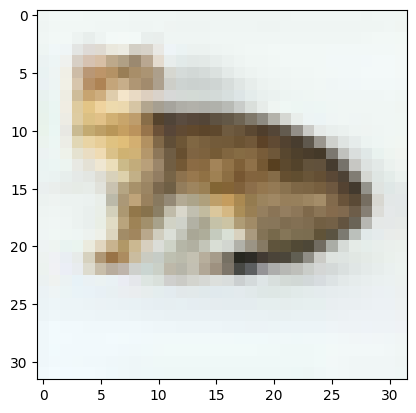

In [ ]:
sample = dataset_val[0]
# (channel, height, width)
print(sample[0].shape, sample[1])
plt.imshow(sample[0].permute(1, 2, 0));

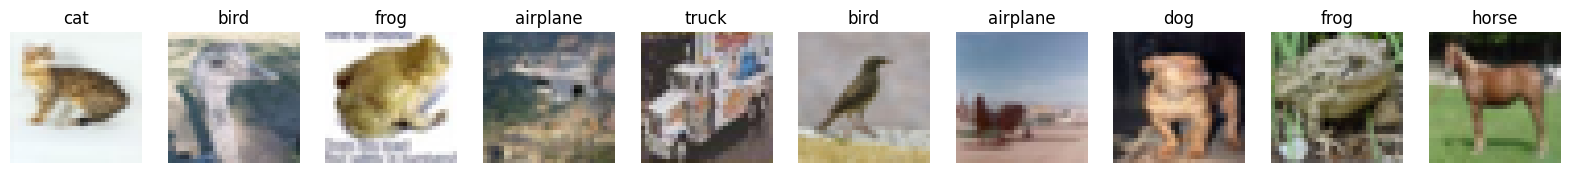

In [ ]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(dataset_val[i][0].permute(1, 2, 0))
    plt.title(id2cls[dataset_val[i][1]])
    plt.axis("off")

plt.show()

## DataLoader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=16, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=False)

In [ ]:
batch = next(iter(dataloader_val))
images, labels = batch
images.shape, labels.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

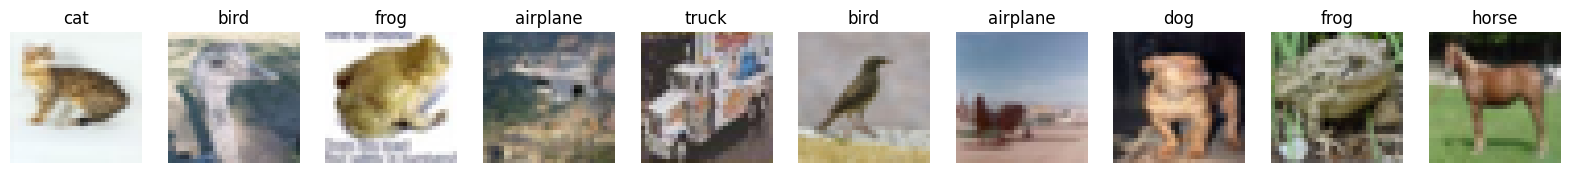

In [ ]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(id2cls[labels[i].item()])
    plt.axis("off")

plt.show()

## Model

In [ ]:
from torch import nn

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.model = nn.Sequential(
            nn.Flatten(),

            nn.Linear(3*32*32, 256),
            nn.ReLU(),

            nn.Linear(256, 256),
            nn.ReLU(),

            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# !pip install -qq torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
model = MLP(num_classes=10)
model = model.to(device)
summary(model, input_data=images.to(device))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [16, 10]                  --
├─Sequential: 1-1                        [16, 10]                  --
│    └─Flatten: 2-1                      [16, 3072]                --
│    └─Linear: 2-2                       [16, 256]                 786,688
│    └─ReLU: 2-3                         [16, 256]                 --
│    └─Linear: 2-4                       [16, 256]                 65,792
│    └─ReLU: 2-5                         [16, 256]                 --
│    └─Linear: 2-6                       [16, 10]                  2,570
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
Total mult-adds (M): 13.68
Input size (MB): 0.20
Forward/backward pass size (MB): 0.07
Params size (MB): 3.42
Estimated Total Size (MB): 3.68

## Loss

- Cross entropy
  - $P$: target
  - $Q$: model

$$
H(P, Q) = -\sum_y P(y) \log Q(y)
$$

Now consider the special case in which the true state of nature is a degenerate distribution, which puts all its mass on a single outcome, say $c$, i.e., $P(y)=\delta(y-c)$ This is often called a "one-hot" distribution, since it turns "on" the $c$'th element of the vector, and leaves the other elements "off". In this case, the cross entropy becomes

$$
H(\delta(y-c), Q(y)) = -\sum_y \delta(y-c) \log Q(y) = -\log Q(y=c)
$$

$$
\begin{align}
L(\phi) & = -\sum_{i=1}^{N}\log [p(y=y_i|x_i)] \\
& = \sum_{i=1}^{N}H(\delta(y-y_i), p(y|x_i)) \\
\end{align}
$$

where $p(y=k|x) = \text{softmax}_{k}(f_\phi(x))$


$$
\frac{1}{N}\sum_{i=1}^{N}H(\delta(y-y_i), p(y|x_i)) = \text{nn.CrossEntropyLoss}(f_\phi(x), y) = \text{nn.NLLLoss}(\text{nn.LogSoftmax}(f_\phi(x)), y)
$$

In [ ]:
logsoftmax = nn.LogSoftmax(dim=1)
nll = nn.NLLLoss()
cel = nn.CrossEntropyLoss()

In [ ]:
model = MLP()
logits = model(batch[0])
logits.shape

torch.Size([16, 10])

In [ ]:
labels = batch[1]
labels.shape

torch.Size([16])

In [ ]:
cel(logits, labels)

tensor(2.2898, grad_fn=<NllLossBackward0>)

In [ ]:
nll(logsoftmax(logits), labels)

tensor(2.2898, grad_fn=<NllLossBackward0>)

In [ ]:
logsoftmax(logits).shape

torch.Size([16, 10])

In [ ]:
softmax = nn.Softmax(dim=1)
probs = softmax(logits)
print(probs.shape)
print(probs[0, :].sum())
probs

torch.Size([16, 10])
tensor(1., grad_fn=<SumBackward0>)


tensor([[0.1098, 0.1027, 0.0867, 0.0976, 0.0810, 0.0961, 0.1192, 0.0941, 0.1047,
         0.1082],
        [0.1080, 0.1013, 0.0908, 0.0956, 0.0883, 0.0975, 0.1141, 0.0960, 0.1045,
         0.1038],
        [0.1098, 0.0993, 0.0868, 0.0992, 0.0801, 0.0993, 0.1165, 0.0945, 0.1054,
         0.1093],
        [0.1058, 0.1004, 0.0938, 0.0963, 0.0889, 0.0976, 0.1132, 0.0939, 0.1037,
         0.1064],
        [0.1051, 0.0992, 0.0903, 0.0967, 0.0922, 0.0966, 0.1115, 0.0961, 0.1042,
         0.1081],
        [0.1088, 0.0996, 0.0901, 0.0963, 0.0865, 0.0983, 0.1139, 0.0934, 0.1058,
         0.1074],
        [0.1060, 0.1006, 0.0903, 0.0980, 0.0853, 0.0992, 0.1127, 0.0944, 0.1067,
         0.1068],
        [0.1086, 0.1010, 0.0923, 0.0967, 0.0908, 0.0991, 0.1115, 0.0938, 0.0998,
         0.1064],
        [0.1050, 0.1014, 0.0908, 0.1004, 0.0911, 0.0967, 0.1107, 0.0945, 0.1035,
         0.1061],
        [0.1042, 0.1007, 0.0905, 0.0992, 0.0910, 0.0983, 0.1120, 0.0945, 0.1026,
         0.1070],
        [0

In [ ]:
torch.allclose(torch.log(softmax(logits)), logsoftmax(logits))

True

In [ ]:
labels

tensor([3, 2, 6, 0, 9, 2, 0, 5, 6, 7, 1, 9, 1, 1, 9, 4])

In [ ]:
import torch.nn.functional as F

In [ ]:
labels_oh = F.one_hot(labels, num_classes=10)
print(labels_oh.shape)
labels_oh

torch.Size([16, 10])


tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [ ]:
# log(p(y=y_i | x_i))
-(torch.log(softmax(logits)) * labels_oh).sum(dim=1).mean()

tensor(2.2898, grad_fn=<NegBackward0>)

## torchmetrics

In [ ]:
model = MLP()

In [ ]:
batch = next(iter(dataloader_val))
images, labels = batch
images.shape, labels.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

In [ ]:
logits = model(batch[0])
logits.shape

torch.Size([16, 10])

In [ ]:
labels = batch[1]
print(labels.shape)
labels

torch.Size([16])


tensor([3, 2, 6, 0, 9, 2, 0, 5, 6, 7, 1, 9, 1, 1, 9, 4])

In [ ]:
preds = torch.argmax(logits, dim=1)
print(preds.shape)
preds

torch.Size([16])


tensor([7, 7, 4, 7, 7, 7, 7, 4, 4, 4, 7, 7, 4, 7, 7, 7])

In [ ]:
# accuracy
(labels == preds).float().mean()

tensor(0.)

In [ ]:
# !pip install -qq torchmetrics

In [ ]:
from torchmetrics.classification import Accuracy, ConfusionMatrix

In [ ]:
accuracy = Accuracy(task="multiclass", num_classes=10)

idx = 10
accs = []
for batch_idx, batch in enumerate(dataloader_val):
  images, labels = batch
  logits = model(images)
  preds = torch.argmax(logits, dim=1)
  acc = accuracy(preds, labels)
  accs.append(acc)
  print(batch_idx, acc)
  if batch_idx == idx:
    break

0 tensor(0.)
1 tensor(0.)
2 tensor(0.1250)
3 tensor(0.0625)
4 tensor(0.1875)
5 tensor(0.2500)
6 tensor(0.2500)
7 tensor(0.1875)
8 tensor(0.)
9 tensor(0.0625)
10 tensor(0.1875)


In [ ]:
sum(accs)/len(accs)

tensor(0.1193)

In [ ]:
accuracy.compute()

tensor(0.1193)

In [ ]:
# !pip install -qq tqdm

In [ ]:
import numpy as np
from tqdm import tqdm

In [ ]:
acc = Accuracy(task="multiclass", num_classes=10)
acc_per_cls = Accuracy(task="multiclass", num_classes=10, average=None)
confmat = ConfusionMatrix(task="multiclass", num_classes=10)

test_preds = []
test_labels = []
for batch in tqdm(dataloader_test):
    images, labels = batch

    with torch.inference_mode():
        logits = model(images)

    preds = torch.argmax(logits, dim=1)

    acc.update(preds, labels)
    acc_per_cls.update(preds, labels)
    confmat.update(preds, labels)

    test_preds.append(preds.numpy())
    test_labels.append(labels.numpy())

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

test_acc = acc.compute()
acc.reset()
print(test_acc)

100%|██████████| 500/500 [00:01<00:00, 386.38it/s]

tensor(0.1060)


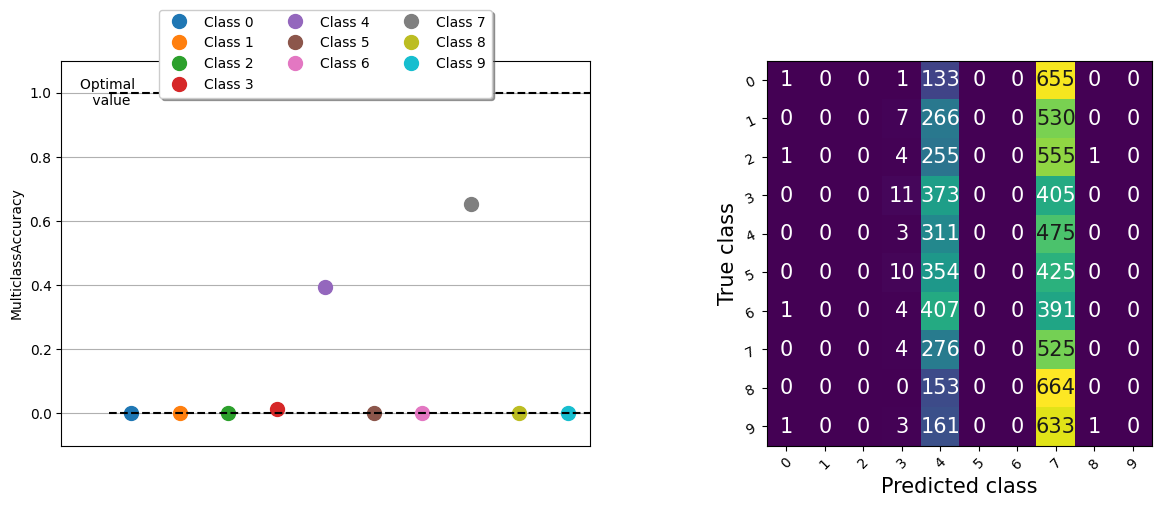

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
acc_per_cls.plot(ax=axes[0])
confmat.plot(ax=axes[1])
plt.show()

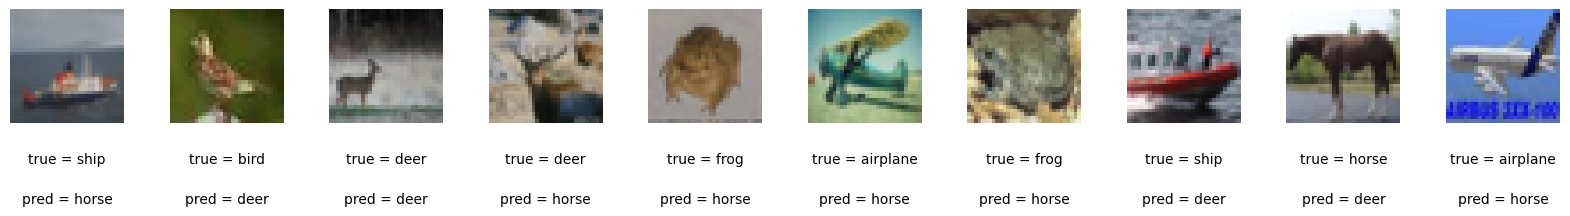

In [ ]:
n_to_show = 10
indices = np.random.choice(range(len(dataset_test)), n_to_show)

fig = plt.figure(figsize=(20, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = dataset_test[idx][0].permute(1, 2, 0)

    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "true = " + id2cls[test_labels[idx]],
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "pred = " + id2cls[test_preds[idx]],
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)

## Training

In [ ]:
from torch import optim
from pathlib import Path

In [ ]:
# DataLoader
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)

# Model, Optimizer, Criterion
model = MLP(num_classes=10)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

# Metrics
accuracy_train = Accuracy(task="multiclass", num_classes=10)
accuracy_train = accuracy_train.to(device)
accuracy_val = Accuracy(task="multiclass", num_classes=10)
accuracy_val = accuracy_val.to(device)

metrics = {
    "train": {"loss": [], "accuracy": []},
    "val": {"loss": [], "accuracy": []},
}

# Results directory
results_dir = Path("results")
results_dir.mkdir(exist_ok=True, parents=True)

best_accuracy = 0
n_epochs = 5
for epoch in range(n_epochs):
    # Training
    model.train()

    loss_train = 0

    tqdm_train = tqdm(dataloader_train)
    tqdm_train.set_description("Epoch {:2d} (Train)".format(epoch))
    for batch in tqdm_train:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        acc = accuracy_train(preds, labels)
        loss_train += loss.item()

    loss_train = loss_train / len(dataloader_train)
    acc_train = accuracy_train.compute()
    accuracy_train.reset()

    print("(Train) loss {:.4f}, accuracy {:.4f}".format(loss_train, acc_train))
    metrics["train"]["loss"].append(loss_train)
    metrics["train"]["accuracy"].append(acc_train.item())

    torch.save(model.state_dict(), results_dir/"last.pth")

    # Validation
    model.eval()

    loss_val = 0

    tqdm_val = tqdm(dataloader_val)
    tqdm_val.set_description("Epoch {:2d} (Val)  ".format(epoch))
    for batch in tqdm_val:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        with torch.inference_mode():
            logits = model(images)
            loss = criterion(logits, labels)

            preds = torch.argmax(logits, dim=1)
            accuracy_val.update(preds, labels)
            loss_val += loss.item()

    loss_val = loss_val / len(dataloader_val)
    acc_val = accuracy_val.compute()
    accuracy_val.reset()

    print("(Val)   loss {:.4f}, accuracy {:.4f}".format(loss_val, acc_val), end="\n\n")
    metrics["val"]["loss"].append(loss_val)
    metrics["val"]["accuracy"].append(acc_val.item())

    if acc_val > best_accuracy:
        best_accuracy = acc_val
        torch.save(model.state_dict(), results_dir/"best.pth")

Epoch  0 (Train): 100%|██████████| 782/782 [00:06<00:00, 123.94it/s]


(Train) loss 1.8382, accuracy 0.3349


Epoch  0 (Val)  : 100%|██████████| 32/32 [00:00<00:00, 113.48it/s]


(Val)   loss 1.6829, accuracy 0.4100



Epoch  1 (Train): 100%|██████████| 782/782 [00:07<00:00, 105.99it/s]


(Train) loss 1.6537, accuracy 0.4092


Epoch  1 (Val)  : 100%|██████████| 32/32 [00:00<00:00, 140.84it/s]


(Val)   loss 1.5846, accuracy 0.4430



Epoch  2 (Train): 100%|██████████| 782/782 [00:07<00:00, 107.87it/s]


(Train) loss 1.5654, accuracy 0.4425


Epoch  2 (Val)  : 100%|██████████| 32/32 [00:00<00:00, 120.42it/s]


(Val)   loss 1.5752, accuracy 0.4335



Epoch  3 (Train): 100%|██████████| 782/782 [00:07<00:00, 102.07it/s]


(Train) loss 1.5101, accuracy 0.4609


Epoch  3 (Val)  : 100%|██████████| 32/32 [00:00<00:00, 128.64it/s]


(Val)   loss 1.4789, accuracy 0.4675



Epoch  4 (Train): 100%|██████████| 782/782 [00:08<00:00, 96.81it/s] 


(Train) loss 1.4693, accuracy 0.4775


Epoch  4 (Val)  : 100%|██████████| 32/32 [00:00<00:00, 130.02it/s]

(Val)   loss 1.4664, accuracy 0.4685



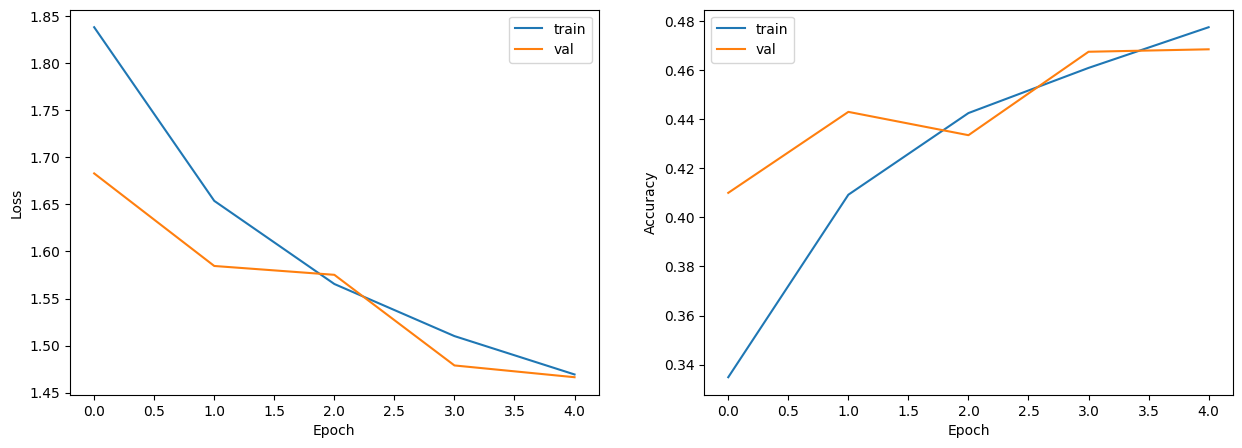

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax = axes[0]
ax.plot(metrics["train"]["loss"], label="train")
ax.plot(metrics["val"]["loss"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

ax = axes[1]
ax.plot(metrics["train"]["accuracy"], label="train")
ax.plot(metrics["val"]["accuracy"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()

plt.show()

## Evaluation

In [ ]:
model.load_state_dict(torch.load(results_dir/"best.pth", weights_only=True))
model.eval()

acc = Accuracy(task="multiclass", num_classes=10)
acc = acc.to(device)

acc_per_cls = Accuracy(task="multiclass", num_classes=10, average=None)
acc_per_cls = acc_per_cls.to(device)

confmat = ConfusionMatrix(task="multiclass", num_classes=10)
confmat = confmat.to(device)

test_loss = 0
test_preds = []
test_labels = []
for batch in tqdm(dataloader_test):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)

    with torch.inference_mode():
        logits = model(images)
        loss = criterion(logits, labels)

        preds = torch.argmax(logits, dim=1)

        acc.update(preds, labels)
        acc_per_cls.update(preds, labels)
        confmat.update(preds, labels)
        test_loss += loss.item()

        test_preds.append(preds.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_loss = test_loss / len(dataloader_test)
test_acc = acc.compute()
acc.reset()
print("(Test)  loss {:.4f}, accuracy {:.4f}".format(test_loss, test_acc))

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

100%|██████████| 125/125 [00:01<00:00, 98.15it/s]


(Test)  loss 1.4753, accuracy 0.4806


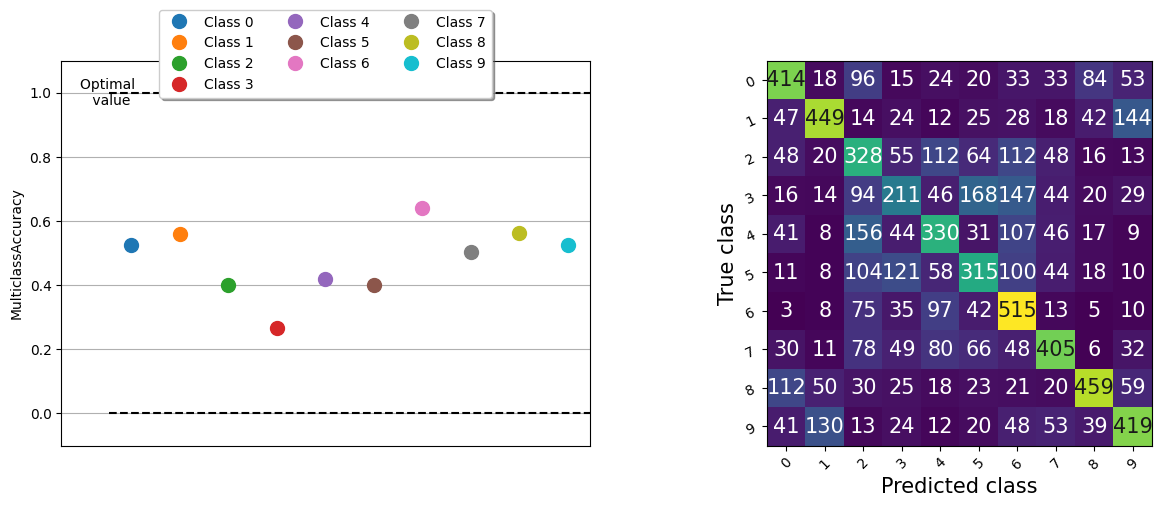

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
acc_per_cls.plot(ax=axes[0])
confmat.plot(ax=axes[1])
plt.show()

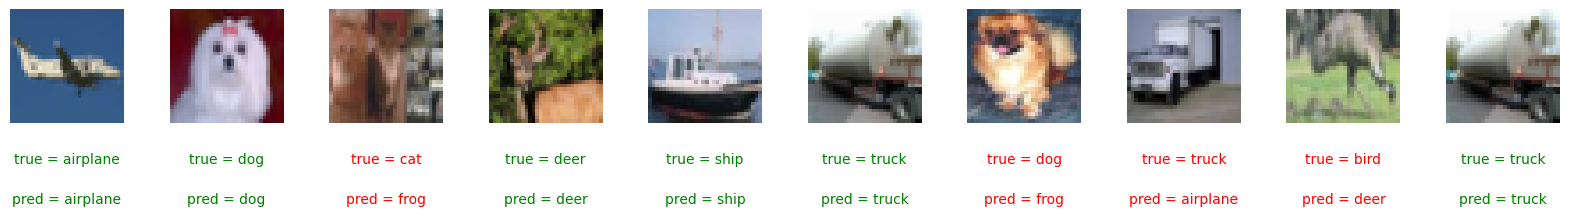

In [ ]:
# Visual evaluation
n_to_show = 10
indices = np.random.choice(range(len(dataset_test)), n_to_show)

fig = plt.figure(figsize=(20, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = dataset_test[idx][0].permute(1, 2, 0)
    true_label = id2cls[test_labels[idx]]
    pred_label = id2cls[test_preds[idx]]

    if true_label == pred_label:
        color = "green"
    else:
        color = "red"

    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "true = " + true_label,
        fontsize=10,
        color=color,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "pred = " + pred_label,
        fontsize=10,
        color=color,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)